In [1]:
import os
import sys 
import glob
import copy
import pyproj
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import xarray as xr
import xarray_sentinel
import drama.utils as drtls
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse, cmod5n_forward
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp
# importing from one directory  up
# sys.path.insert(0, "../" )
# from .misc import round_to_hour, angular_difference, calculate_distance

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from velocity_leakage import S1DopplerLeakage

In [2]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
storage_dir = "data_processed/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios

['Carrib_20231104',
 'Azores_20201127',
 'Hawaii_20201106',
 'Barbedos_20201110',
 'Morroco_20201103',
 'Iceland_20231107',
 'Scotland_20231109']

In [3]:
scenarios = ['Azores_20201127']

In [3]:
beam_pattern = "phased_array"

for scenario in scenarios:

    # ----------------------------------------
    files = glob.glob(f"{data_dir+scenario}/*")

    test = S1DopplerLeakage(
        filename=files,    
        # era5_file='era5_winds/era5_wind_202011.nc',
        era5_directory= 'era5_winds/',
        scene_size=50_000,
        beam_pattern=beam_pattern, # ["sinc", "phased_array"]
        )

    var_2_save = ["nrcs_scat", "doppler_pulse_rg", "V_leakage_pulse_rg"]

    # ------------------- Compute scatterometer performance from Sentinel-1 ---------------------
    test.open_data()
    
    # copy the data at this step
    test_copy = copy.deepcopy(test)

    test.querry_era5()
    test.wdir_from_era5()
    test.create_dataset()
    test.create_beam_mask()
    test.compute_scatt_eqv_backscatter()
    test.compute_beam_pattern()
    test.compute_Doppler_leakage()
    test.data[var_2_save].to_netcdf(f"{storage_dir+scenario}_4ML_{beam_pattern}.nc")
    test.subscenes.to_netcdf(f"{storage_dir+scenario}_4ML_subscenes_{beam_pattern}.nc")

    # ------------------- Interpolate scatterometer NRCS to Sentinel-1 resolution --------------------
    slow_time_upsamp = np.linspace(test.data.slow_time.min().values, test.data.slow_time.max().values, test_copy.S1_file.azimuth_time.count().values)
    nrcs_scat_upsamp = test.data.nrcs_scat.interp(slow_time = slow_time_upsamp)
    inc_scat_upsamp = test.data.inc_scatt_eqv.mean(dim='az_idx').interp(slow_time = slow_time_upsamp)

    test_copy.S1_file['NRCS_VV'] = (['azimuth_time', 'ground_range'], nrcs_scat_upsamp.T.values)
    test_copy.S1_file['inc'] = (['azimuth_time', 'ground_range'], inc_scat_upsamp.T.values)


    # ------------------- Estimate velocity leakage from scatteromter NRCS --------------------
    test_copy.querry_era5()
    test_copy.wdir_from_era5()
    test_copy.create_dataset()
    test_copy.create_beam_mask()
    test_copy.compute_scatt_eqv_backscatter()
    test_copy.compute_beam_pattern()
    test_copy.compute_Doppler_leakage()

    test_copy.data[var_2_save].to_netcdf(f"{storage_dir+scenario}_4ML_inverse_{beam_pattern}.nc")
    test_copy.subscenes.to_netcdf(f"{storage_dir+scenario}_4ML_subscenes_inverse_{beam_pattern}.nc")


# - Review processed data

### Single scene example

In [5]:
scenario = "Azores_20201127"
beam_pattern = "phased_array"
data = xr.open_dataset(f"data_processed/{scenario}_4ML_{beam_pattern}.nc")
data_inverse = xr.open_dataset(f"data_processed/{scenario}_4ML_inverse_{beam_pattern}.nc")

data_subscene = xr.open_dataset(f"data_processed/{scenario}_4ML_subscenes_{beam_pattern}.nc")
data_subscene_inverse = xr.open_dataset(f"data_processed/{scenario}_4ML_subscenes_inverse_{beam_pattern}.nc")

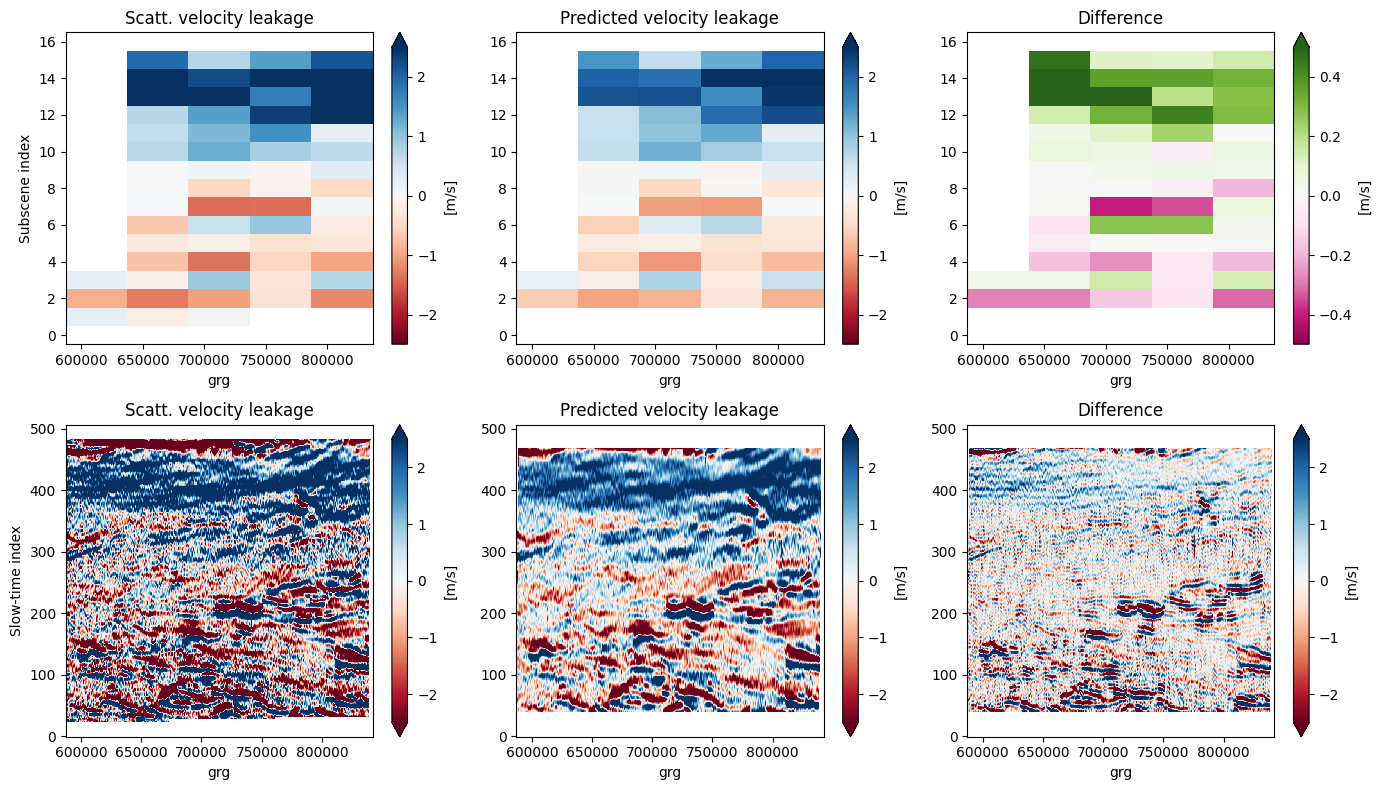

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=False, sharey=False)

vmin = -2.5
vmax = 2.5

data_subscene.V_leakage_pulse_rg.T.plot(robust = True, ax=axes[0,0], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
data_subscene_inverse.V_leakage_pulse_rg.T.plot(robust = True, ax=axes[0,1], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
(data_subscene.V_leakage_pulse_rg.T - data_subscene_inverse.V_leakage_pulse_rg.T).plot(robust = True, ax=axes[0,2], vmin=vmin/5, vmax=vmax/5,cmap='PiYG', cbar_kwargs={"label": "[m/s]"})

axes[0,0].set_ylabel('Subscene index')
axes[0,1].set_ylabel('')
axes[0,2].set_ylabel('')
axes[0,0].set_title('Scatt. velocity leakage')
axes[0,1].set_title('Predicted velocity leakage')
axes[0,2].set_title('Difference')

data.V_leakage_pulse_rg.T.plot(robust = True, ax=axes[1,0], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
data_inverse.V_leakage_pulse_rg.T.plot(robust = True, ax=axes[1,1], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
(data.V_leakage_pulse_rg.T - data_inverse.V_leakage_pulse_rg.T).plot(robust = True, ax=axes[1,2], vmin=vmin, vmax=vmax,cmap='RdBu', cbar_kwargs={"label": "[m/s]"})

axes[1,0].set_ylabel('Slow-time index')
axes[1,1].set_ylabel('')
axes[1,2].set_ylabel('')
axes[1,0].set_title('Scatt. velocity leakage')
axes[1,1].set_title('Predicted velocity leakage')
axes[1,2].set_title('Difference')
fig.tight_layout()

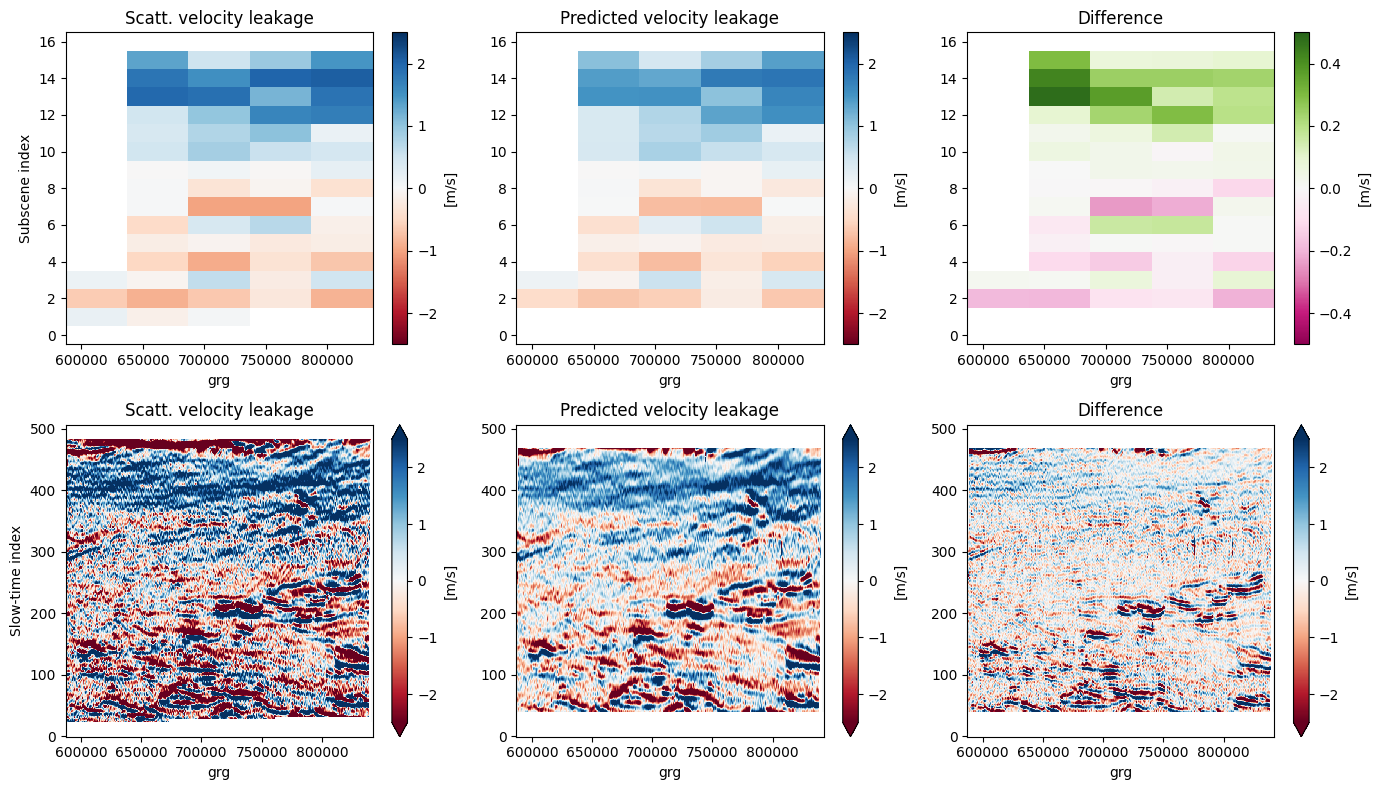

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=False, sharey=False)

vmin = -2.5
vmax = 2.5

data_subscene.V_leakage_pulse_rg.T.plot(robust = True, ax=axes[0,0], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
data_subscene_inverse.V_leakage_pulse_rg.T.plot(robust = True, ax=axes[0,1], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
(data_subscene.V_leakage_pulse_rg.T - data_subscene_inverse.V_leakage_pulse_rg.T).plot(robust = True, ax=axes[0,2], vmin=vmin/5, vmax=vmax/5,cmap='PiYG', cbar_kwargs={"label": "[m/s]"})

axes[0,0].set_ylabel('Subscene index')
axes[0,1].set_ylabel('')
axes[0,2].set_ylabel('')
axes[0,0].set_title('Scatt. velocity leakage')
axes[0,1].set_title('Predicted velocity leakage')
axes[0,2].set_title('Difference')

data.V_leakage_pulse_rg.T.plot(robust = True, ax=axes[1,0], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
data_inverse.V_leakage_pulse_rg.T.plot(robust = True, ax=axes[1,1], vmin=vmin, vmax=vmax, cmap='RdBu', cbar_kwargs={"label": "[m/s]"})
(data.V_leakage_pulse_rg.T - data_inverse.V_leakage_pulse_rg.T).plot(robust = True, ax=axes[1,2], vmin=vmin, vmax=vmax,cmap='RdBu', cbar_kwargs={"label": "[m/s]"})

axes[1,0].set_ylabel('Slow-time index')
axes[1,1].set_ylabel('')
axes[1,2].set_ylabel('')
axes[1,0].set_title('Scatt. velocity leakage')
axes[1,1].set_title('Predicted velocity leakage')
axes[1,2].set_title('Difference')
fig.tight_layout()

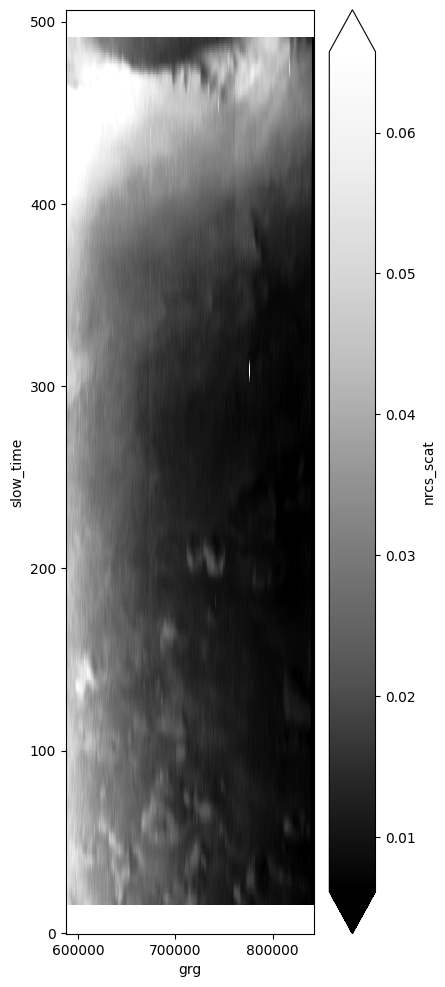

In [37]:
data.nrcs_scat.T.plot(robust=True, cmap= 'Greys_r', figsize=(4,12), aspect='auto')

### All scenes 

In [4]:
data_dir = "/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/"
data_type = "4ML_subscenes_phased_array.nc"
scenarios = glob.glob(f"{data_dir}*{data_type}")
scenarios

['/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Hawaii_20201106_4ML_subscenes_phased_array.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Barbedos_20201110_4ML_subscenes_phased_array.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Scotland_20231109_4ML_subscenes_phased_array.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Iceland_20231107_4ML_subscenes_phased_array.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Morroco_20201103_4ML_subscenes_phased_array.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Azores_20201127_4ML_subscenes_phased_array.nc',
 '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Carrib_20231104_4ML_subscenes_phased_array.nc']

In [5]:
for scenario in scenarios:
    dir_sinc = scenario[:-16]+'_sinc.nc'
    dir_sinc_inv = scenario[:-16]+'_inverse_sinc.nc'
    dir_phased_array = scenario
    dir_phased_array_inv = scenario[:-16]+'_inverse_phased_array.nc'

    data_phased_array = xr.open_dataset(dir_phased_array).V_leakage_pulse_rg
    data_sinc = xr.open_dataset(dir_sinc).V_leakage_pulse_rg
    data_inversed_phased_array = xr.open_dataset(dir_phased_array_inv).V_leakage_pulse_rg
    data_inversed_sinc = xr.open_dataset(dir_sinc_inv).V_leakage_pulse_rg

    diff_phased_array = data_phased_array - data_inversed_phased_array
    diff_sinc = data_sinc - data_inversed_sinc

    perf_phased_array = np.sqrt(np.nanmean(diff_phased_array**2)), np.nanmedian(diff_phased_array)
    perf_sinc = np.sqrt(np.nanmean(diff_sinc**2)), np.nanmedian(diff_sinc)

    print(f"sinc,   RMSE: {perf_sinc[0]:.3f} m/s, median error: {perf_sinc[1]:.3f} m/s")
    print(f"phased, RMSE: {perf_phased_array[0]:.3f} m/s, median error: {perf_phased_array[1]:.3f} m/s")
    

sinc,   RMSE: 0.086 m/s, median error: -0.001 m/s
phased, RMSE: 0.131 m/s, median error: -0.010 m/s
sinc,   RMSE: 0.072 m/s, median error: 0.019 m/s
phased, RMSE: 0.109 m/s, median error: 0.027 m/s
sinc,   RMSE: 0.148 m/s, median error: 0.010 m/s
phased, RMSE: 0.224 m/s, median error: 0.015 m/s
sinc,   RMSE: 0.090 m/s, median error: -0.005 m/s
phased, RMSE: 0.137 m/s, median error: -0.027 m/s
sinc,   RMSE: 0.069 m/s, median error: -0.010 m/s
phased, RMSE: 0.101 m/s, median error: -0.019 m/s
sinc,   RMSE: 0.161 m/s, median error: 0.028 m/s
phased, RMSE: 0.242 m/s, median error: 0.036 m/s
sinc,   RMSE: 0.077 m/s, median error: 0.012 m/s
phased, RMSE: 0.116 m/s, median error: 0.023 m/s


In [33]:
for scenario in scenarios:
    dir_sinc = scenario[:-16]+'_sinc.nc'
    dir_sinc_inv = scenario[:-16]+'_inverse_sinc.nc'
    dir_phased_array = scenario
    dir_phased_array_inv = scenario[:-16]+'_inverse_phased_array.nc'

    data_phased_array = xr.open_dataset(dir_phased_array).V_leakage_pulse_rg
    data_sinc = xr.open_dataset(dir_sinc).V_leakage_pulse_rg
    data_inversed_phased_array = xr.open_dataset(dir_phased_array_inv).V_leakage_pulse_rg
    data_inversed_sinc = xr.open_dataset(dir_sinc_inv).V_leakage_pulse_rg

    diff_phased_array = data_phased_array - data_inversed_phased_array
    diff_sinc = data_sinc - data_inversed_sinc

    perf_phased_array = np.sqrt(np.nanmean(diff_phased_array**2)), np.nanmedian(diff_phased_array)
    perf_sinc = np.sqrt(np.nanmean(diff_sinc**2)), np.nanmedian(diff_sinc)

    print(f"sinc,   RMSE: {perf_sinc[0]:.3f} m/s, median error: {perf_sinc[1]:.3f} m/s")
    print(f"phased, RMSE: {perf_phased_array[0]:.3f} m/s, median error: {perf_phased_array[1]:.3f} m/s")
    

sinc,   RMSE: 0.086 m/s, median error: -0.001 m/s
phased, RMSE: 0.310 m/s, median error: -0.049 m/s
sinc,   RMSE: 0.072 m/s, median error: 0.019 m/s
phased, RMSE: 0.243 m/s, median error: 0.087 m/s
sinc,   RMSE: 0.148 m/s, median error: 0.010 m/s
phased, RMSE: 0.517 m/s, median error: 0.020 m/s
sinc,   RMSE: 0.090 m/s, median error: -0.005 m/s
phased, RMSE: 0.335 m/s, median error: -0.026 m/s
sinc,   RMSE: 0.069 m/s, median error: -0.010 m/s
phased, RMSE: 0.224 m/s, median error: -0.040 m/s
sinc,   RMSE: 0.161 m/s, median error: 0.028 m/s
phased, RMSE: 0.546 m/s, median error: 0.108 m/s
sinc,   RMSE: 0.077 m/s, median error: 0.012 m/s
phased, RMSE: 0.252 m/s, median error: 0.038 m/s
